# **Sesión 1:** Calibración de Cámara 📷⚙️

## **Instalaciones**

In [2]:
# !pip uninstall numpy -y
# !pip uninstall opencv-python -y
!pip install numpy==1.26 opencv-python==4.8.0.76

In [38]:
# Create necesary directories
!mkdir ..\output
!mkdir ..\output\left
!mkdir ..\output\left_cornersubpix
!mkdir ..\output\right
!mkdir ..\output\right_cornersubpix
!mkdir ..\output\fisheye_cornersubpix
!mkdir ..\output\fisheye_undistorted

Ya existe el subdirectorio o el archivo ..\output.
Ya existe el subdirectorio o el archivo ..\output\left.
Ya existe el subdirectorio o el archivo ..\output\left_cornersubpix.
Ya existe el subdirectorio o el archivo ..\output\right.
Ya existe el subdirectorio o el archivo ..\output\right_cornersubpix.
Ya existe el subdirectorio o el archivo ..\output\fisheye_cornersubpix.


## **Librerías**

In [4]:
from typing import List
import numpy as np
import imageio
import cv2
import copy
import glob

## **Apartado A: Calibración de cámara** (derecha e izquierda)

En este apartado se realiza la calibración de dos cámaras de un sistema estereoscópico. Para ello se trabajará con las imágenes de las carpetas ``left`` y ``right``. En primer lugar se trabajará con la carpeta ``left``. Posteriormente, deberá repetir el proceso con las imágenes en la carpeta ``right``. Ambas carpetas contienen imágenes con las que se calibrarán las cámaras. En ellas aparece el patrón de calibración en diferentes posiciones y orientaciones. Estas imágenes serán los datos de entrada.

Los pasos que deberá seguir para calibrar una cámara son:

1. Defina y ejecute el método para cargar imágenes ``load_images()``.
2. Detecte las esquinas de los patrones usando ``cv2.findChessboardCorners()``. Refine las detecciones con ``cv2.cornerSubPix()``.
3. Compruebe que las detecciones son correctas dibujando los resultados con ``cv2.drawChessboardCorners()``.
4. Defina y ejecute el método ``get_chessboard_points(chessboard_shape, dx, dy)`` que proporcione las coordenadas 3D de las esquinas del patrón. El sistema de referencia utilizado deberá estar anclado al propio patrón.
5. Utilice ``cv2.calibrateCamera`` para obtener los parámetros de calibración para la cámara izquierda.

### **Tarea A.1:** Defina y ejecute el método para cargar imágenes ``load_images()``.

In [5]:
def load_images(filenames: List) -> List:
    return [imageio.imread(filename) for filename in filenames]

In [6]:
# TODO Build a list containing the paths of all images from the left camera
import os
path = '../data/left/'
imgs_path = [path + file_name for file_name in os.listdir(path)]
imgs = load_images(imgs_path)

# Quito la primera imagen porque no me detecta las esquinas
imgs = imgs[1:]
imgs_left = copy.deepcopy(imgs)

C:\Users\enriq\AppData\Local\Temp\ipykernel_12472\283608422.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return [imageio.imread(filename) for filename in filenames]


### **Tarea A.2:** Detecte las esquinas de los patrones usando ``cv2.findChessboardCorners()``. Refine las detecciones con ``cv2.cornerSubPix()``.

In [7]:
# TODO Find corners with cv2.findChessboardCorners()
corners = [cv2.findChessboardCorners(img, (8, 6)) for img in imgs]

In [8]:
corners_copy = copy.deepcopy(corners)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)

# TODO To refine corner detections with cv2.cornerSubPix() you need to input grayscale images. Build a list containing grayscale images.
imgs_gray = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in imgs]
imgs_gray_left = copy.deepcopy(imgs_gray)

corners_refined_left = [cv2.cornerSubPix(i, cor[1], (6, 6), (-1, -1), criteria) if cor[0] else np.array([]) for i, cor in zip(imgs_gray, corners_copy)]

### **Tarea A.3:** Compruebe que las detecciones son correctas dibujando los resultados con ``cv2.drawChessboardCorners()``

In [9]:
imgs_copy = copy.deepcopy(imgs)

In [10]:
# TODO Use cv2.drawChessboardCorners() to draw the corners
imgs_corners = [cv2.drawChessboardCorners(img, (8, 6), cor[1], cor[0]) for img, cor in zip(imgs_copy, corners)]

In [11]:
# TODO Show images and save when needed

def show_image(img):
	cv2.imshow('image', img)
	cv2.waitKey(0)
	cv2.destroyAllWindows()
    
def write_image(i, img, folder):
	cv2.imwrite(f'../output/{folder}/' + str(i) + '.jpg', img) 

for i, img in enumerate(imgs_corners):    
	show_image(img)
	write_image(i, img, 'left')

### **Tarea A.4:** Defina y ejecute el método ``get_chessboard_points(chessboard_shape, dx, dy)``

In [12]:
# TODO Design the method. It should return a np.array with np.float32 elements
def get_chessboard_points(chessboard_shape, dx, dy):
	points = []
	for i in range(chessboard_shape[1]):
		for j in range(chessboard_shape[0]):
			points.append([i*dx, j*dy, 0])
	return np.array(points, np.float32)

In [13]:
# TODO You need the points for every image, not just one
chessboard_points = [get_chessboard_points((8, 6), 30, 30)] * len(imgs)

### **Tarea A.5:** Utilice ``cv2.calibrateCamera()`` para obtener los parámetros de calibración para la cámara izquierda

In [14]:
# Filter data and get only those with adequate detections
valid_corners = [cor[1] for cor in corners if cor[0]]
# Convert list to numpy array
valid_corners = np.asarray(valid_corners, dtype=np.float32)
valid_corners_left = copy.deepcopy(valid_corners)

In [15]:
# TODO
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(chessboard_points, valid_corners, imgs_gray[0].shape[::-1], np.zeros((3,3)), np.zeros((1,4)))

# Obtain extrinsics
extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))

In [16]:
# Print outputs
print("Intrinsics:\n", intrinsics)
print("Distortion coefficients:\n", dist_coeffs)
print("Root mean squared reprojection error:\n", rms)

Intrinsics:
 [[419.43707122   0.         149.75969166]
 [  0.         420.8835093  128.61357119]
 [  0.           0.           1.        ]]
Distortion coefficients:
 [[ 2.42284124e-02 -3.34226604e+00  4.88771677e-03 -6.97578217e-03
   2.00632089e+01]]
Root mean squared reprojection error:
 0.15254912898003242


### **Pregunta A.1:** Repita el proceso (carga de imágenes, detección y comprobación de esquinas, etc.) para la cámara derecha.

In [17]:
# TODO Homework

path = '../data/right/'
imgs_path = [path + file_name for file_name in os.listdir(path)]
imgs = load_images(imgs_path)
imgs_right = copy.deepcopy(imgs)

C:\Users\enriq\AppData\Local\Temp\ipykernel_12472\283608422.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return [imageio.imread(filename) for filename in filenames]


In [18]:
corners = [cv2.findChessboardCorners(img, (8, 6)) for img in imgs]

corners_copy = copy.deepcopy(corners)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)

imgs_gray = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in imgs]

In [19]:
imgs_copy = copy.deepcopy(imgs)

imgs_corners = [cv2.drawChessboardCorners(img, (8, 6), cor[1], cor[0]) for img, cor in zip(imgs_copy, corners)]

for i, img in enumerate(imgs_corners):    
	show_image(img)
	write_image(i, img, 'right')

In [20]:
def get_valid_imgs(imgs, corners):
	valid_imgs = []
	valid_imgs_gray = []
	valid_corners = []
	for i, cor in enumerate(corners):
		if cor[0]:
			valid_imgs.append(imgs[i])
			valid_imgs_gray.append(cv2.cvtColor(imgs[i], cv2.COLOR_RGB2GRAY))
			valid_corners.append(cor[1])

	# Convert list to numpy array
	valid_corners = np.asarray(valid_corners, dtype=np.float32)

	return valid_imgs, valid_imgs_gray, valid_corners

valid_imgs_right, valid_imgs_gray_right, valid_corners = get_valid_imgs(imgs_right, corners)
valid_corners_right = copy.deepcopy(valid_corners)
chessboard_points = [get_chessboard_points((8, 6), 30, 30)] * len(valid_imgs_right)

corners_refined_right = [cv2.cornerSubPix(i, cor, (3, 3), (-1, -1), criteria) for i, cor in zip(valid_imgs_gray_right, valid_corners_right)]

In [21]:
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(chessboard_points, valid_corners, valid_imgs_gray_right[0].shape[::-1], np.zeros((3,3)), np.zeros((1,4)))

# Obtain extrinsics
extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))

# Print outputs
print("Intrinsics:\n", intrinsics)
print("Distortion coefficients:\n", dist_coeffs)
print("Root mean squared reprojection error:\n", rms)
print("Extrinsics:\n", extrinsics)

Intrinsics:
 [[431.71537857   0.         146.86695587]
 [  0.         434.75795189 137.57408161]
 [  0.           0.           1.        ]]
Distortion coefficients:
 [[-0.11760795 -0.26326294  0.00634024 -0.00786122  1.68828721]]
Root mean squared reprojection error:
 0.20463921316160896
Extrinsics:
 [array([[ 6.15913503e-01,  7.14606746e-01,  3.31644019e-01,
        -9.17909706e+01],
       [ 6.17781957e-01, -1.76873297e-01, -7.66199250e-01,
        -3.65664883e+01],
       [-4.88872182e-01,  6.76796155e-01, -5.50409806e-01,
         5.25925288e+02]]), array([[ 6.01220226e-01,  7.17600875e-01,  3.51544057e-01,
        -1.18280061e+02],
       [ 6.51692452e-01, -1.85742730e-01, -7.35388731e-01,
        -4.62579627e+01],
       [-4.62418845e-01,  6.71229188e-01, -5.79327360e-01,
         5.17809074e+02]]), array([[ 5.83118753e-01,  7.27505898e-01,  3.61535183e-01,
        -1.29643058e+02],
       [ 6.82697207e-01, -1.97611154e-01, -7.03473067e-01,
        -6.13012932e+01],
       [-4.40

### **Pregunta A.2:** Diferencias entre cv2.findChessboardCorners() y cv2.cornerSubPix()

In [22]:
# TODO Homework
imgs_corners_left = [cv2.drawChessboardCorners(img, (8, 6), cor, True) for img, cor in zip(imgs_left, corners_refined_left)]
imgs_corners_right = [cv2.drawChessboardCorners(img, (8, 6), cor, True) for img, cor in zip(valid_imgs_right, corners_refined_right)]

for i, img in enumerate(imgs_corners_left):    
	show_image(img)
	write_image(i, img, 'left_cornersubpix')

for i, img in enumerate(imgs_corners_right):    
	show_image(img)
	write_image(i, img, 'right_cornersubpix')

#### Error de left con cv.cornerSubPix()

In [23]:
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(chessboard_points, corners_refined_left, imgs_gray_left[0].shape[::-1], np.zeros((3,3)), np.zeros((1,4)))

# Obtain extrinsics
extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))

# Print outputs
print("Intrinsics:\n", intrinsics)
print("Distortion coefficients:\n", dist_coeffs)
print("Root mean squared reprojection error:\n", rms)

Intrinsics:
 [[420.34844385   0.         149.49830627]
 [  0.         421.09434871 128.8368256 ]
 [  0.           0.           1.        ]]
Distortion coefficients:
 [[-2.33350267e-02 -2.13281958e+00  4.05360055e-03 -6.81871867e-03
   1.12715657e+01]]
Root mean squared reprojection error:
 0.09147505617249294


#### Error de right con cv.cornerSubPix()

In [24]:
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(chessboard_points, corners_refined_right, valid_imgs_gray_right[0].shape[::-1], np.zeros((3,3)), np.zeros((1,4)))

# Obtain extrinsics
extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))

# Print outputs
print("Intrinsics:\n", intrinsics)
print("Distortion coefficients:\n", dist_coeffs)
print("Root mean squared reprojection error:\n", rms)

Intrinsics:
 [[430.76992911   0.         145.23316559]
 [  0.         432.06924533 136.97901747]
 [  0.           0.           1.        ]]
Distortion coefficients:
 [[-0.11610352 -0.1381798   0.00705097 -0.00595672  1.18788066]]
Root mean squared reprojection error:
 0.10760044853606197


### **Pregunta A.3:** Número mínimo de imágenes necesarias para calibrar.

In [25]:
# TODO Homework
import matplotlib.pyplot as plt

### LEFT

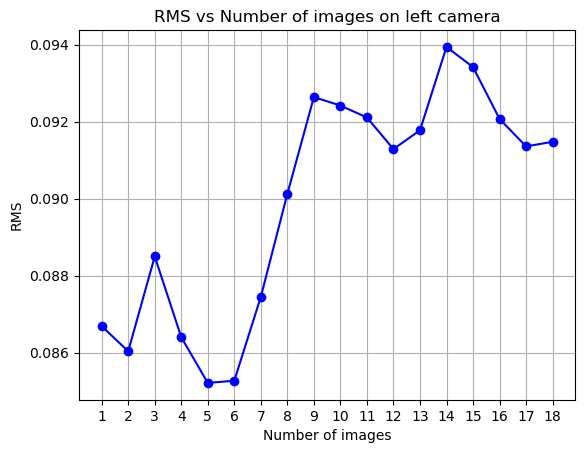

In [26]:
rms_list = []
for i in range(1, len(imgs_gray_left) + 1):
	chessboard_points = [get_chessboard_points((8, 6), 30, 30)] * i
	corners_refined_left_i = corners_refined_left[:i]
	imgs_gray_left_i = imgs_gray_left[:i]

	rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(chessboard_points, corners_refined_left_i, imgs_gray_left_i[0].shape[::-1], np.zeros((3,3)), np.zeros((1,4)))
	rms_list.append(rms)

# Hacer un diagrama de Pareto haciendo discreto el eje x, con la  linea azul
plt.plot(range(1, len(imgs_gray_left) + 1), rms_list, c='b', marker='o')
plt.xlabel('Number of images')
plt.ylabel('RMS')
plt.title('RMS vs Number of images on left camera')
plt.xticks(range(1, len(imgs_gray_left) + 1))
plt.grid()
plt.show()

### RIGHT

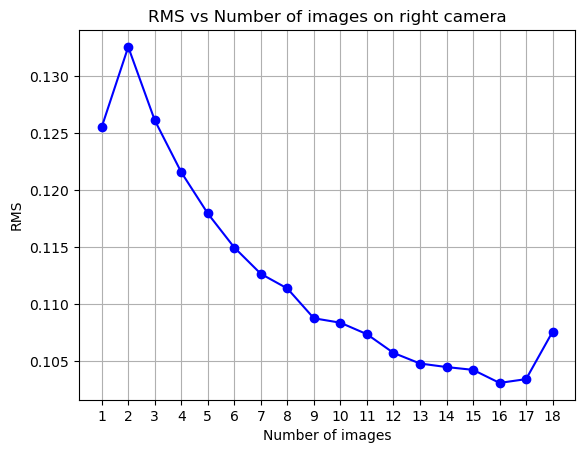

In [27]:
rms_list = []
for i in range(1, len(valid_imgs_gray_right) + 1):
	chessboard_points = [get_chessboard_points((8, 6), 30, 30)] * i
	corners_refined_right_i = corners_refined_right[:i]
	imgs_gray_right_i = valid_imgs_gray_right[:i]

	rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(chessboard_points, corners_refined_right_i, imgs_gray_right_i[0].shape[::-1], np.zeros((3,3)), np.zeros((1,4)))
	rms_list.append(rms)

# Hacer un diagrama de Pareto haciendo discreto el eje x, con la  linea azul
plt.plot(range(1, len(imgs_gray_left) + 1), rms_list, c='b', marker='o')
plt.xlabel('Number of images')
plt.ylabel('RMS')
plt.title('RMS vs Number of images on right camera')
plt.xticks(range(1, len(imgs_gray_left) + 1))
plt.grid()
plt.show()

## **Apartado B: Corrección de distorsión** (ojo de pez)

En este apartado se trabajará en la corrección de la distorsión debido a lentes de ojo de pez. Primero se calibrará una cámara con este tipo de lente, utilizando las imágenes de la carpeta ``fisheye``. Posteriormente se utilizarán estos parámetros de calibración para corregir la distorsión de una de las imágenes de calibración.

Los pasos que deberá seguir para calibrar una cámara con distorsión de ojo de pez son:

1. Reutilice el método ``load_images()`` para cargar las imágenes de la carpeta ``fisheye``.
2. Detecte las equinas procesando las imágenes con los métodos ``cv2.findChessboardCorners()`` y ``cv2.cornerSubPix()``.
3. Reutilice la función ``get_chessboard_points()`` para obtener las coordenadas del tablero.
4. Defina los argumentos para la función de calibración.
5. Calibre con ``cv2.fisheye.calibrate()``

### **Tarea B.1:** Reutilice el método ``load_images()`` para cargar las imágenes de la carpeta ``fisheye``

In [41]:
# TODO Build a list containing the paths of all images from the fisheye camera and load images
path = "../data/fisheye/"
fisheye_imgs_path = [path + file_name for file_name in os.listdir(path)]
fisheye_imgs = load_images(fisheye_imgs_path)

C:\Users\enriq\AppData\Local\Temp\ipykernel_12472\283608422.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return [imageio.imread(filename) for filename in filenames]


### **Tarea B.2:** Detecte las equinas procesando las imágenes con los métodos ``cv2.findChessboardCorners()`` y ``cv2.cornerSubPix()``.

In [42]:
fisheye_imgs_copy = copy.deepcopy(fisheye_imgs)
imgs_corners = []
valid_fisheye_imgs = []
# Parameters for cv2.cornerSubPix()
subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)

#TODO Complete the required parts of the loop
for img in fisheye_imgs_copy:
    
    # TODO parse arguments to cv2.findChessboardCorners()
    corners = cv2.findChessboardCorners(img, (7, 6))

    # TODO convert image to grayscale to use cv2.cornerSubPix()
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    refined_corners = cv2.cornerSubPix(gray_img, corners[1], (3,3), (-1,-1), subpix_criteria) if corners[0] else np.array([])

    # TODO append only those refined_corners with proper detections
    imgs_corners.append(refined_corners) if corners[0] else None
    valid_fisheye_imgs.append(img) if corners[0] else None

imgs_corners = np.asarray(imgs_corners, dtype=np.float32)
len(valid_fisheye_imgs)

10

In [43]:
# draw corners
imgs_corners_copy = copy.deepcopy(imgs_corners)
draw_imgs_corners = [cv2.drawChessboardCorners(img, (7, 6), cor, True) for img, cor in zip(valid_fisheye_imgs, imgs_corners_copy)]

for i, img in enumerate(draw_imgs_corners):
	show_image(img)
	write_image(i, img, 'fisheye_cornersubpix')

### **Tarea B.3:** Reutilice la función ``get_chessboard_points()`` para obtener las coordenadas del tablero

In [44]:
# TODO Define the chessboard dimensions and the lenght of the squares (in [mm])
chessboard_dims = (7, 6)
length = 30
fisheye_chessboard_points = np.asarray([get_chessboard_points(chessboard_dims, length, length).reshape(-1, 1, 3)] * len(valid_fisheye_imgs))

### **Tarea B.4:** Defina los argumentos para la calibración

In [45]:
# Parameters for cv2.fisheye.calibrate()
num_imgs = len(valid_fisheye_imgs)

calibration_flags = cv2.fisheye.CALIB_FIX_SKEW + cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC
intrinsics = np.zeros((3, 3), dtype=np.float64)
distortion = np.zeros((4, 1))
rotations = [np.zeros((1, 1, 3), dtype=np.float64) for _ in range(num_imgs)]
translations = [np.zeros((1, 1, 3), dtype=np.float64) for _ in range(num_imgs)]

In [46]:
print(f"fisheye_chessboard_points shape: {fisheye_chessboard_points.shape}")
print(f"imgs_corners length: {len(imgs_corners)}")

fisheye_chessboard_points shape: (10, 42, 1, 3)
imgs_corners length: 10


### **Tarea B.5:** Calibración

In [47]:
rms, _, _, _, _ = \
cv2.fisheye.calibrate(fisheye_chessboard_points, imgs_corners, gray_img.shape[::-1], intrinsics, distortion, rotations, translations, calibration_flags, subpix_criteria)

In [48]:
# Show intrinsic matrix and distortion coefficients values
print("Intrinsics:\n", intrinsics)
print("Distortion coefficients:\n", distortion)

Intrinsics:
 [[188.86930773   0.         503.92797129]
 [  0.         185.32647765 373.58041071]
 [  0.           0.           1.        ]]
Distortion coefficients:
 [[ 0.07734283]
 [ 0.01482764]
 [ 0.02351267]
 [-0.0275728 ]]


### **Pregunta B.1:** Corrija la distorsión de las 2 primeras imágenes de la carpeta ``fisheye``

In [49]:
# TODO Search in the documentation to define 'dim'
dim = gray_img.shape[::-1]
map1, map2 = cv2.fisheye.initUndistortRectifyMap(intrinsics, distortion, np.eye(3), intrinsics, dim, cv2.CV_16SC2)

In [50]:
# TODO Homework: correct distortion using cv2.remap()
undistorted_imgs = [cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT) for img in valid_fisheye_imgs[:2]]

for i, img in enumerate(undistorted_imgs):
	show_image(img)
	write_image(i, img, 'fisheye_undistorted')